In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `~/Documents/datacubes_in_julia_workshop`
Precompiling project...
  ✓ Rasters → RastersRasterDataSourcesExt
  ✓ WGLMakie
  2 dependencies successfully precompiled in 46 seconds. 504 already precompiled.


# General introduction to YAXArrays.jl and mapCube

So far we have only used `mapslices` in this tutorial. However, this can only cover very simple cases for a single input cube and computations on one or dimensions which either collapse or return the same dimension. 

In [187]:
using DimensionalData, YAXArrays, Zarr, NetCDF
using GLMakie

In [189]:
path = "https://s3.bgc-jena.mpg.de:9000/deepextremes/v3/ERA5Cube.zarr"
path = "examples/data/era5_germany.zarr"
c = Cube(open_dataset(zopen(path,consolidated=true,fill_as_missing=false)))

#c = Cube(joinpath(tutorialdir,"esdc_subset2.zarr"))

╭───────────────────────────────────────────────────╮
│ 60×120×9131×5 YAXArray{Union{Missing, Float64},4} │
├───────────────────────────────────────────────────┴──────────────────── dims ┐
  ↓ longitude Sampled{Float32} 0.0f0:0.25f0:14.75f0 ForwardOrdered Regular Points,
  → latitude  Sampled{Float32} 60.0f0:-0.25f0:30.25f0 ReverseOrdered Regular Points,
  ↗ Ti        Sampled{DateTime} [1998-01-01T00:00:00, …, 2022-12-31T00:00:00] ForwardOrdered Irregular Points,
  ⬔ Variable  Categorical{String} ["tp", "pet", "t2mmin", "t2mmax", "t2m"] Unordered
├──────────────────────────────────────────────────────────────────── metadata ┤
  Dict{String, Any} with 7 entries:
  "long_name"     => "2 metre temperature"
  "scale_factor"  => 0.00160009
  "_FillValue"    => -32767.0
  "missing_value" => -32767
  "units"         => "K"
  "add_offset"    => 268.035
  "aggfun"        => "mean"
├─────────────────────────────────────────────────────────────────── file size ┤ 
  file size: 2.45 GB
└───────────

In [196]:
c[latitude=Near(11)]

╭───────────────────────────────────────────────╮
│ 60×9131×5 YAXArray{Union{Missing, Float64},3} │
├───────────────────────────────────────────────┴──────────────────────── dims ┐
  ↓ longitude Sampled{Float32} 0.0f0:0.25f0:14.75f0 ForwardOrdered Regular Points,
  → Ti        Sampled{DateTime} [1998-01-01T00:00:00, …, 2022-12-31T00:00:00] ForwardOrdered Irregular Points,
  ↗ Variable  Categorical{String} ["tp", "pet", "t2mmin", "t2mmax", "t2m"] Unordered
├──────────────────────────────────────────────────────────────────── metadata ┤
  Dict{String, Any} with 7 entries:
  "long_name"     => "2 metre temperature"
  "scale_factor"  => 0.00160009
  "_FillValue"    => -32767.0
  "missing_value" => -32767
  "units"         => "K"
  "add_offset"    => 268.035
  "aggfun"        => "mean"
├─────────────────────────────────────────────────────────────────── file size ┤ 
  file size: 20.9 MB
└──────────────────────────────────────────────────────────────────────────────┘

## The `mapCube` function

is a generalization of mapslices, where you can annotate the exact signature of the function to be applied. For example the computation of the `median` over time can be written using `mapCube`. 
Here one hase to specify the dimension(s) that the user-defined function is going to operate on. For the computation of the median over time the only input dimension is `time` and there are no output dimensions as only a single value is returned. The user defined function passed to `mapCube` always has the signature `f(outputs..., inputs...)` and potentially followd by additional arguments and keyword args. 

## Apply function along single Axis

In [203]:
using Statistics 
indims = InDims("latitude")
outdims = OutDims()
function apply_median(xout, xin)
    x = filter(!ismissing, xin)

    x = filter(!isnan,x)
    #@show x

    #filter!(!ismissing, x)
    xout[] = isempty(x) ? missing : median(x)
end

apply_median (generic function with 1 method)

In [204]:
medians = mapCube(apply_median, c[Variable=Where(contains("t2m"))];indims, outdims)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:22


╭───────────────────────────────────────────────╮
│ 60×9131×3 YAXArray{Union{Missing, Float64},3} │
├───────────────────────────────────────────────┴──────────────────────── dims ┐
  ↓ longitude Sampled{Float32} 0.0f0:0.25f0:14.75f0 ForwardOrdered Regular Points,
  → Ti        Sampled{DateTime} [1998-01-01T00:00:00, …, 2022-12-31T00:00:00] ForwardOrdered Irregular Points,
  ↗ Variable  Categorical{String} ["t2mmin", "t2mmax", "t2m"] Unordered
├──────────────────────────────────────────────────────────────────── metadata ┤
  Dict{String, Any}()
├─────────────────────────────────────────────────────────────────── file size ┤ 
  file size: 12.54 MB
└──────────────────────────────────────────────────────────────────────────────┘

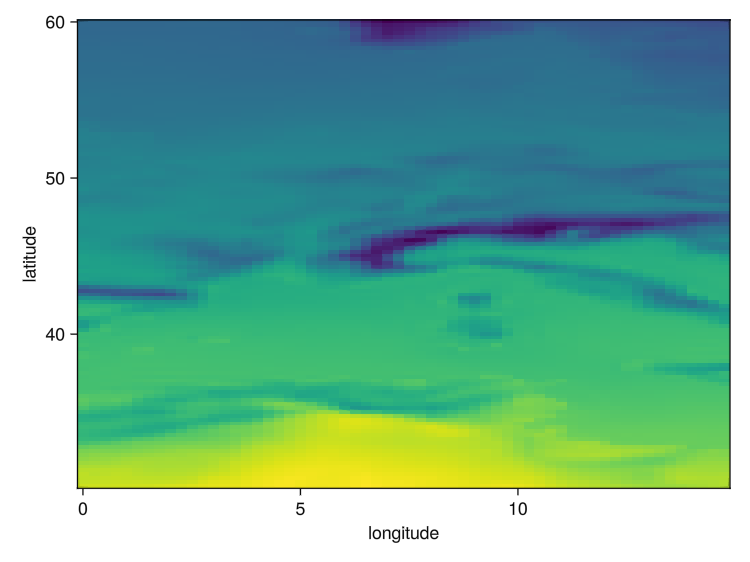

In [10]:
fig, ax, heat = heatmap(DimArray(medians[Variable=At("t2m")]))

## Apply function on all elements

In [200]:
medians_kelvin = map(x-> x + 273.15, medians)

╭──────────────────────────────╮
│ 60×120×3 YAXArray{Float64,3} │
├──────────────────────────────┴───────────────────────────────────────── dims ┐
  ↓ longitude Sampled{Float32} 0.0f0:0.25f0:14.75f0 ForwardOrdered Regular Points,
  → latitude  Sampled{Float32} 60.0f0:-0.25f0:30.25f0 ReverseOrdered Regular Points,
  ↗ Variable  Categorical{String} ["t2mmin", "t2mmax", "t2m"] Unordered
├──────────────────────────────────────────────────────────────────── metadata ┤
  Dict{String, Any}()
├─────────────────────────────────────────────────────────────────── file size ┤ 
  file size: 168.75 KB
└──────────────────────────────────────────────────────────────────────────────┘

This function is applied lazily and only computed when the data is worked with. This could be a mapCube operation, saving the data to disk or plotting the data. 

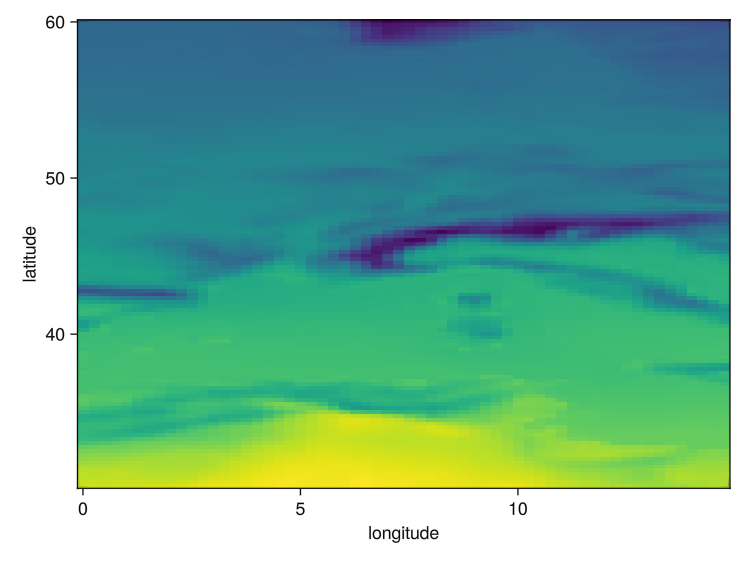

In [14]:
heatmap(DimArray(medians_kelvin[Variable=At("t2m")]))

## Arguments for inner function and output dimensions

Let's make a slightly more complex computation to demonstrate a case where multiple outputs are generated. For examples, imagine we want to normalize every time series (to zero mean and unit variance), but at the same time return the means and variances in a single dataset for later re-use:

## Apply function with multiple output cubes

In [15]:
function norm(ts_out, mean_out, std_out, ts_in)
    x = filter(!ismissing, ts_in)

    tsshort = filter(!isnan,x)
    if isempty(tsshort)
        ts_out .= missing
        mean_out[] = missing
        std_out[] = missing
    else
        mean_out[] = mean(tsshort)
        std_out[] = std(tsshort)
        ts_out .= (ts_in .- mean_out[])./std_out[]
    end
end

norm (generic function with 1 method)

In [201]:
using NetCDF
indims = InDims("Time")
od_ts = OutDims("Time",path = "./normalized_ts.zarr",
                backend=:zarr,overwrite=true)
od_m = OutDims(path = "./means.nc",backend=:netcdf, overwrite=true)
od_s = OutDims(path = "./stds.nc",backend=:netcdf, overwrite=true)
outdims = (od_ts, od_m, od_s)
tsnorm, means, stds = mapCube(norm,c[Variable=Where(contains("t2m"))],indims=indims, outdims=outdims);

┌ Warning: There are still cache misses
└ @ YAXArrays.DAT ~/.julia/packages/YAXArrays/b5XBB/src/DAT/DAT.jl:1091
Progress: 100%|█████████████████████████████████████████| Time: 0:00:27


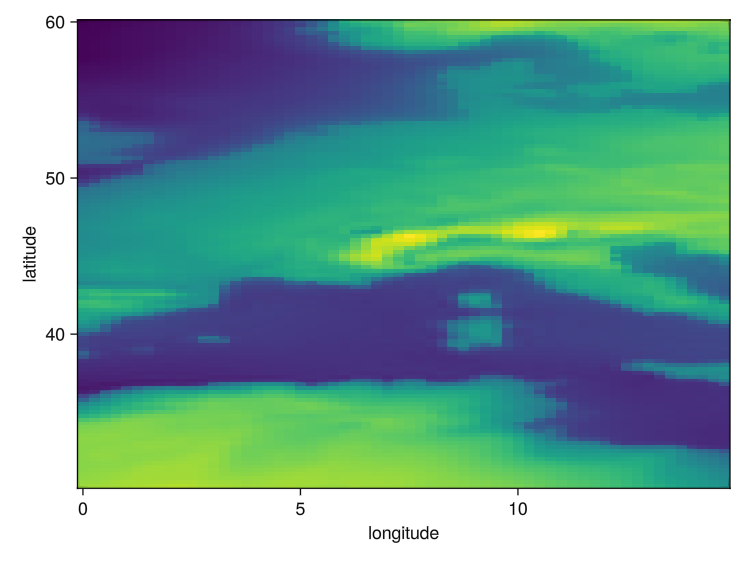

In [18]:
heatmap(DimArray(stds[Variable=At("t2m")]))

## Apply function on moving window

In [19]:
function meanfilter(xout, xin)
    if ismissing(xin[2,2])
        xout .= missing
    else
    xout .= mean(skipmissing(xin))
    end
end

meanfilter (generic function with 1 method)

InDims((MovingWindow(YAXArrays.ByName("Longitude"), 1, 1), MovingWindow(YAXArrays.ByName("Latitude"), 1, 1)), Array, (YAXArrays.DAT.AllMissing(),), missing)

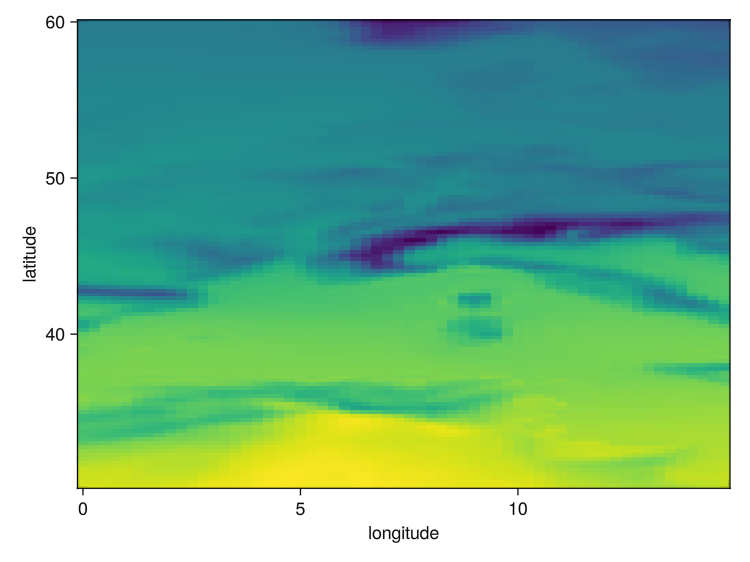

In [23]:
heatmap(DimArray(means[Variable=At("t2m")]))

In [25]:
indims = InDims(MovingWindow("Longitude", 1,1),MovingWindow("Latitude", 1, 1))

InDims((MovingWindow(YAXArrays.ByName("Longitude"), 1, 1), MovingWindow(YAXArrays.ByName("Latitude"), 1, 1)), Array, (YAXArrays.DAT.AllMissing(),), missing)

In [26]:
filteredmeans = mapCube(meanfilter, means, indims=indims, outdims=OutDims())

╭──────────────────────────────────────────────╮
│ 60×120×3 YAXArray{Union{Missing, Float64},3} │
├──────────────────────────────────────────────┴───────────────────────── dims ┐
  ↓ longitude Sampled{Float32} 0.0f0:0.25f0:14.75f0 ForwardOrdered Regular Points,
  → latitude  Sampled{Float32} 60.0f0:-0.25f0:30.25f0 ReverseOrdered Regular Points,
  ↗ Variable  Categorical{String} ["t2mmin", "t2mmax", "t2m"] Unordered
├──────────────────────────────────────────────────────────────────── metadata ┤
  Dict{String, Any}()
├─────────────────────────────────────────────────────────────────── file size ┤ 
  file size: 168.75 KB
└──────────────────────────────────────────────────────────────────────────────┘

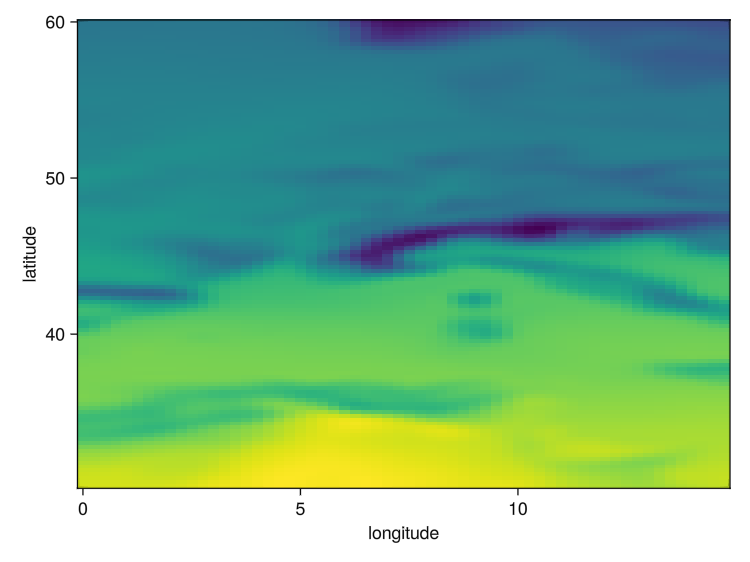

In [28]:
heatmap(DimArray(filteredmeans[Variable=At("t2m")]))

## Define new output dimensions

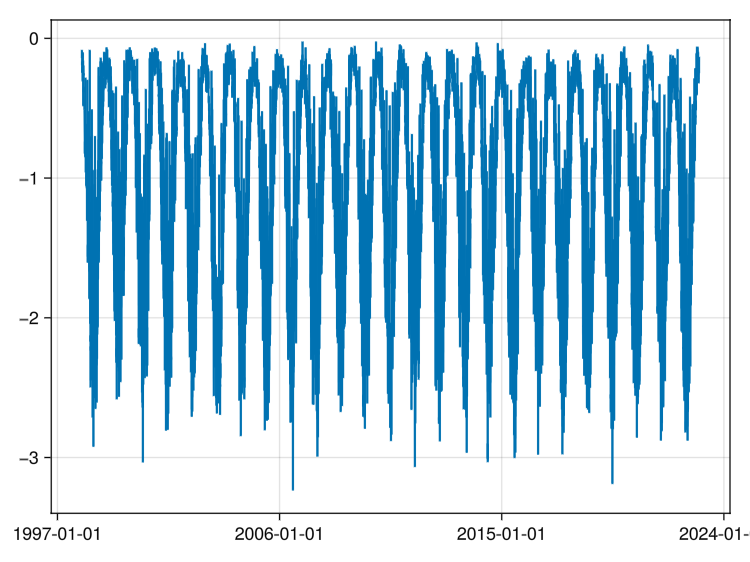

In [202]:
using Dates
pet = c[Variable=At("pet"),
        lon=Near(11.3464),lat=Near(46.4946)]
fig,ax, pl = lines(lookup(pet, Ti).data,pet.data)
fig


So far the function applied here were very simple statistics. Just to stress again, that we are running arbitrary Julia code here, so for example if we want to use some package for time series decomposition like `SignalDecomposition.jl`:

In [117]:
using SignalDecomposition: decompose as dc
dates = lookup(pet, Ti)
stlres = dc(dates,pet.data[:],TimeAnomaly())


(Union{Missing, Float64}[-0.2179934424161911, -0.20928881764411927, -0.20897322714328767, -0.21114868730306624, -0.21699910402297973, -0.22623103886842727, -0.23713505744934082, -0.22183332800865174, -0.21028000205755235, -0.2306227567791939  …  -0.21521896719932557, -0.22888486623764037, -0.22120810568332672, -0.2258425298333168, -0.18495007410645484, -0.1927527430653572, -0.21903749734163283, -0.22075375124812127, -0.2123503002524376, -0.22102486819028855], [0.07212983489036559, 0.12007363587617875, 0.016321627497673047, 0.010126643478870379, 0.0447257512807846, -0.02646666735410691, 0.023116727471351628, 0.01910907983779908, -0.037465690672397606, -0.015707161724567403  …  -0.04578303694725036, -0.04393423557281495, -0.10722677886486054, -0.06792834967374803, -0.1087824796140194, -0.045740744173526776, 0.029219845235347736, 0.057732231467962275, 0.07286720603704452, -0.03237605363130569])

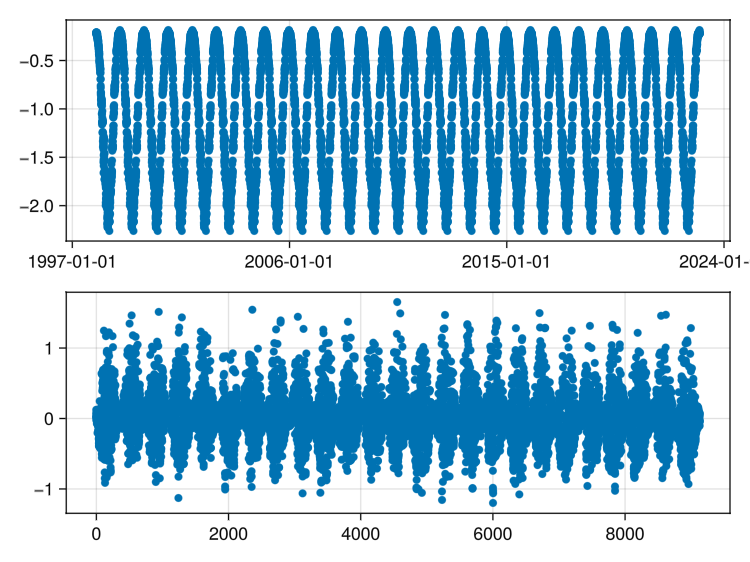

In [118]:
fig,ax, p = plot(dates, stlres[1])
ax2 = Axis(fig[2,1])
plot!(ax2,stlres[2])
fig

In order to apply this over a full array we define the usual Trio: indims, outdims and the function to be applied. Here we create a new dimension for the output. There are 2 types of axes in YAXArrays, `CategoricalAxis` for unordered and `RangeAxis` for ordered dimensions. Here we create a categorical axis for our outputs. This means that inside the function the input array `xin` is a vector with of length `n_timesteps` and the output is a matrix of size `n_timesteps x 3` 

In [208]:
import Logging
Logging.disable_logging(Logging.Info)
indims = InDims("time")
outdims = OutDims(dims(c,Ti),Dim{:Scale}(["Seasonal", "anomalies", "trend"]), 
                    path = "decomposed.zarr",backend=:zarr, overwrite=true)
function decompose_TS(xout, xin, dates)
    any(isnan,xin) && return xout .= missing
    seas, anomaly = dc(dates,xin,TimeAnomaly())

    xout[:,1] = seas
    xout[:,2] = anomaly
end

decompose_TS (generic function with 2 methods)

In [209]:
using Logging
Logging.disable_logging(Warn)


LogLevel(1001)

In [210]:
@time dec = mapCube(decompose_TS, 
    c[Variable=At("t2m")],
    lookup(c, Ti),
        #lon=Near(11.3464),lat=Near(46.4946)],
    indims = indims,
    outdims = outdims)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:16


 17.304097 seconds (518.97 k allocations: 12.075 GiB, 19.60% gc time, 4.81% compilation time: 5% of which was recompilation)


╭───────────────────────────────────────────────────╮
│ 9131×3×60×120 YAXArray{Union{Missing, Float64},4} │
├───────────────────────────────────────────────────┴──────────────────── dims ┐
  ↓ Ti        Sampled{DateTime} [1998-01-01T00:00:00, …, 2022-12-31T00:00:00] ForwardOrdered Irregular Points,
  → Scale     Categorical{String} ["Seasonal", "anomalies", "trend"] ForwardOrdered,
  ↗ longitude Sampled{Float32} 0.0f0:0.25f0:14.75f0 ForwardOrdered Regular Points,
  ⬔ latitude  Sampled{Float32} 60.0f0:-0.25f0:30.25f0 ReverseOrdered Regular Points
├──────────────────────────────────────────────────────────────────── metadata ┤
  Dict{String, Any} with 1 entry:
  "missing_value" => 1.0e32
├─────────────────────────────────────────────────────────────────── file size ┤ 
  file size: 1.47 GB
└──────────────────────────────────────────────────────────────────────────────┘

In [213]:
dec[Scale=At("trend")][1,1,1]

missing

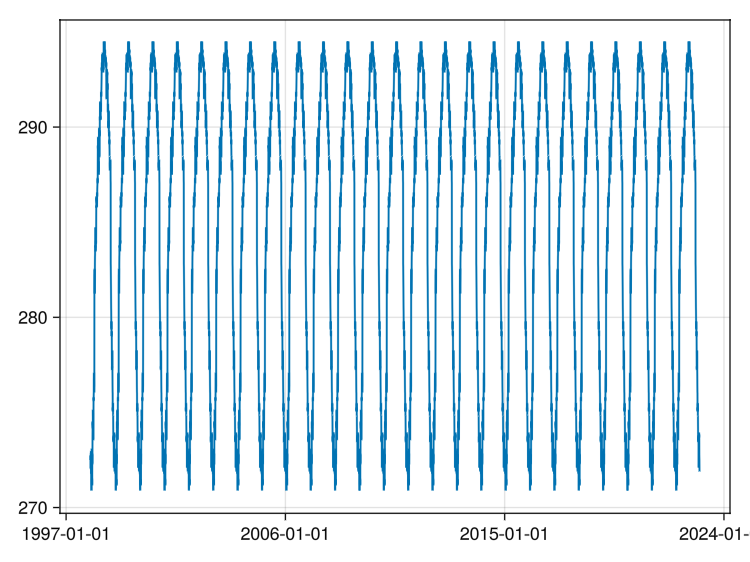

In [128]:
fig, axseas, heatyax = lines( lookup(dec, Ti).data,
    dec[lon=Near(11.3464),lat=Near(46.4946)].data[:,1])
fig

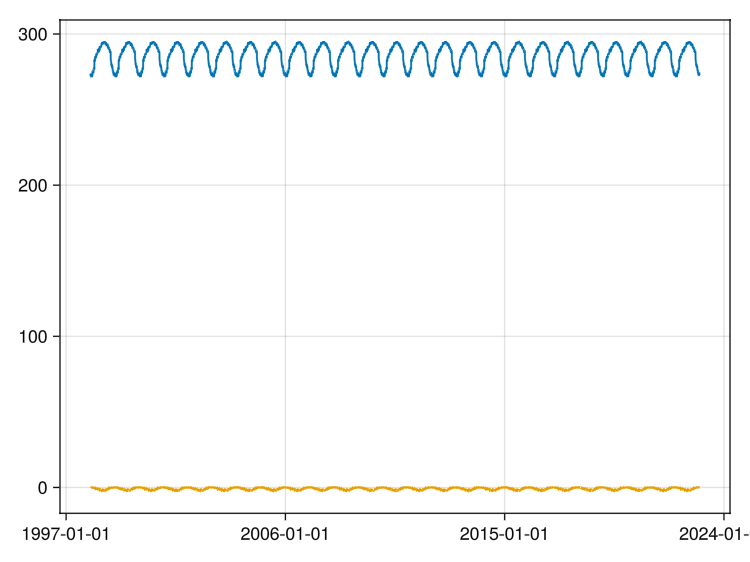

In [129]:
lines!(lookup(dec, Ti).data,
    stlres[1])
fig

You see that the resulting array is a 4-dimensional array including the newly created axis. Lets do some plots:

In [214]:
#Compute variance and plot a map of seasonal variance
scalevar = mapslices(var,dec,dims="Time")
scalerange = mapslices(x->maximum(x) - minimum(x), dec, dims="Time")


Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


╭──────────────────────────────────────────────╮
│ 3×60×120 YAXArray{Union{Missing, Float64},3} │
├──────────────────────────────────────────────┴───────────────────────── dims ┐
  ↓ Scale     Categorical{String} ["Seasonal", "anomalies", "trend"] ForwardOrdered,
  → longitude Sampled{Float32} 0.0f0:0.25f0:14.75f0 ForwardOrdered Regular Points,
  ↗ latitude  Sampled{Float32} 60.0f0:-0.25f0:30.25f0 ReverseOrdered Regular Points
├──────────────────────────────────────────────────────────────────── metadata ┤
  Dict{String, Any}()
├─────────────────────────────────────────────────────────────────── file size ┤ 
  file size: 168.75 KB
└──────────────────────────────────────────────────────────────────────────────┘

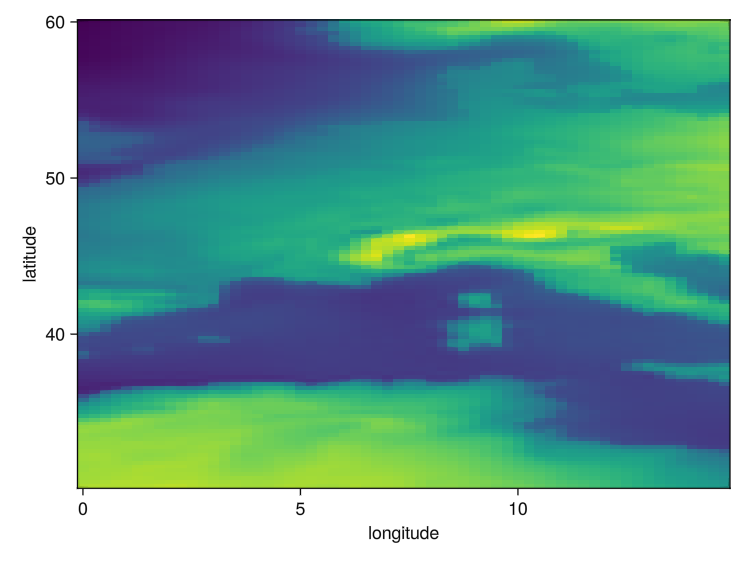

In [215]:
heatmap(scalerange[scale=At("Seasonal")])

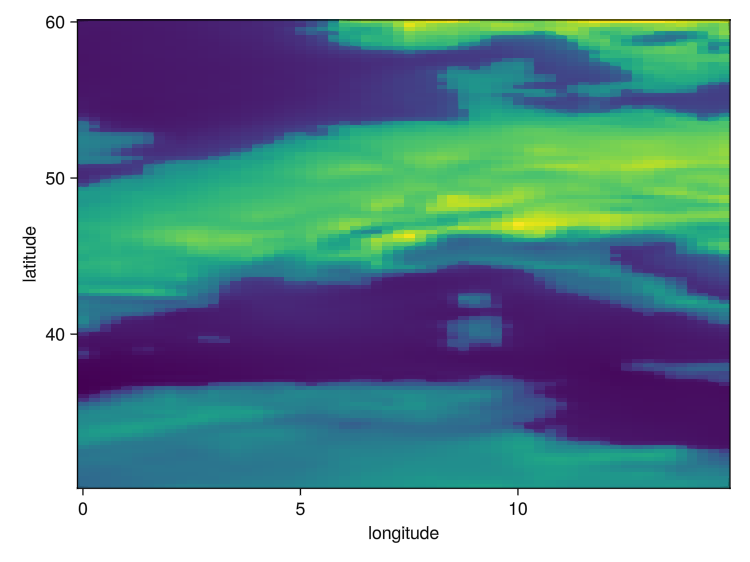

In [134]:
heatmap(scalevar[scale=At("Anomalies")])

## Use Python or R in inner function

In [216]:
using PythonCall
scipyndimage = pyimport("scipy.ndimage")

Python: <module 'scipy.ndimage' from '/home/fcremer/Documents/datacubes_in_julia_workshop/.CondaPkg/env/lib/python3.11/site-packages/scipy/ndimage/__init__.py'>

In [217]:
using Missings
function gaussian_smooth(xout, xin)
    missinds = .!ismissing.(xin)
    cleanin = disallowmissing(xin[missinds])
    smooth = scipyndimage.gaussian_filter(cleanin, sigma=4)
    @show typeof(smooth)
    xout[missinds] .= pyconvert(Vector, smooth)
end

gaussian_smooth (generic function with 1 method)

In [218]:
pet_bozen_2010 = c[lon=Near(11.3464),lat=Near(46.4946),
    time = DateTime(2010)..DateTime(2011),
    Variable=At("pet")]

╭─────────────────────────────────────────────────╮
│ 366-element YAXArray{Union{Missing, Float64},1} │
├─────────────────────────────────────────────────┴────────────────────── dims ┐
  ↓ Ti Sampled{DateTime} [2010-01-01T00:00:00, …, 2011-01-01T00:00:00] ForwardOrdered Irregular Points
├──────────────────────────────────────────────────────────────────── metadata ┤
  Dict{String, Any} with 7 entries:
  "long_name"     => "2 metre temperature"
  "scale_factor"  => 0.00160009
  "_FillValue"    => -32767.0
  "missing_value" => -32767
  "units"         => "K"
  "add_offset"    => 268.035
  "aggfun"        => "mean"
├─────────────────────────────────────────────────────────────────── file size ┤ 
  file size: 2.86 KB
└──────────────────────────────────────────────────────────────────────────────┘

In [179]:
using Missings
petmem = disallowmissing(readcubedata(pet_bozen_2010).data)
    nonmissinds = .!ismissing.(petmem)
view(petmem, missinds )
disallowmissing(collect(petmem))
    smooth = scipyndimage.gaussian_filter(Py(petmem), sigma=4)
pyconvert(Vector, smooth)


366-element Vector{Float64}:
 -0.20947191824107503
 -0.20786497579570723
 -0.20465640440264146
 -0.19989198896057644
 -0.19371428895556875
 -0.18642674583753666
 -0.17854864660268832
 -0.170819448768491
 -0.16415695811908448
 -0.1595515443494284
 -0.15791556103771393
 -0.15991493211223523
 -0.165821864432495
  ⋮
 -0.19183842922579553
 -0.19297147060104072
 -0.19454924295451503
 -0.19636165985783383
 -0.19828051031105437
 -0.20026221811539333
 -0.20232703740922714
 -0.20448304420071506
 -0.20666356852784157
 -0.20868838009851914
 -0.2102810803779923
 -0.21116425369016745

In [180]:
smoothcube = mapCube(gaussian_smooth, gpp_bozen_2010, indims=InDims("time"), outdims=OutDims("time"))

typeof(smooth) = Py


╭─────────────────────────────────────────────────╮
│ 366-element YAXArray{Union{Missing, Float64},1} │
├─────────────────────────────────────────────────┴────────────────────── dims ┐
  ↓ Ti Sampled{DateTime} [2010-01-01T00:00:00, …, 2011-01-01T00:00:00] ForwardOrdered Irregular Points
├──────────────────────────────────────────────────────────────────── metadata ┤
  Dict{String, Any}()
├─────────────────────────────────────────────────────────────────── file size ┤ 
  file size: 2.86 KB
└──────────────────────────────────────────────────────────────────────────────┘

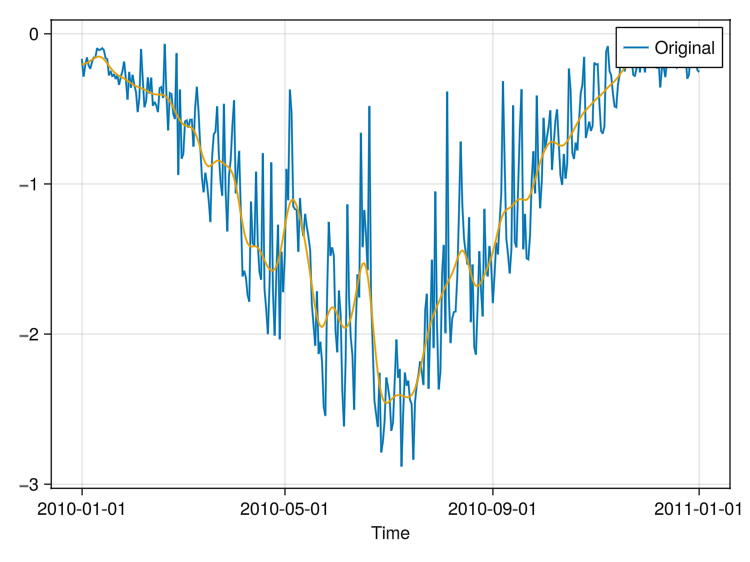

In [186]:
fig, ax, l = lines(pet_bozen_2010, label="Original")
lines!(ax,smoothcube, label="Smooth")
#axislegend(ax)
fig

## Parellelize the data processing

## Easy parallelization on multiple cores and multiple nodes¶
* Use threads on a single computer 
* Use Distributed on multiple computers
* Works also with ClusterManagers like SLURM

In [219]:
using Distributed, Zarr
addprocs(4);

In [28]:
@everywhere begin 
    using Pkg
    Pkg.activate(".")
    Pkg.instantiate()
    #Pkg.status()
    using YAXArrays, Statistics, NetCDF, Zarr
end

  Activating project at `~/Documents/conferences/202310_Bozen_OEMC_GW23`


      From worker 12:	  Activating project at `~/Documents/conferences/202310_Bozen_OEMC_GW23`
      From worker 13:	  Activating project at `~/Documents/conferences/202310_Bozen_OEMC_GW23`
      From worker 10:	  Activating project at `~/Documents/conferences/202310_Bozen_OEMC_GW23`
      From worker 11:	  Activating project at `~/Documents/conferences/202310_Bozen_OEMC_GW23`



# Creating a SAR data cube from GDAL VRTs



- Combine multiple Tif files into one data cube for time series analysis 
- Use Sentinel-1 data as an example

In [167]:
# Load needed packages
using Dates
using ArchGDAL: ArchGDAL as AG
using YAXArrays
using DimensionalData

In [168]:
# Find relevant data
folder = "/home/fcremer/Daten/Tutorials/s1data"
pol = "VH"
allfiles = Iterators.flatten([joinpath.((t[1],), t[3]) for t in walkdir(folder)])
nonhiddenfiles = Iterators.filter(x->!startswith(basename(x),"."), allfiles)
filteredfiles = collect(Iterators.filter(x->occursin(pol,x), nonhiddenfiles))


4-element Vector{String}:
 "/home/fcremer/Daten/Tutorials/s" ⋯ 30 bytes ⋯ "228_127_VH_grd_mli_norm_geo.tif"
 "/home/fcremer/Daten/Tutorials/s" ⋯ 30 bytes ⋯ "253_127_VH_grd_mli_norm_geo.tif"
 "/home/fcremer/Daten/Tutorials/s" ⋯ 30 bytes ⋯ "244_127_VH_grd_mli_norm_geo.tif"
 "/home/fcremer/Daten/Tutorials/s" ⋯ 30 bytes ⋯ "309_127_VH_grd_mli_norm_geo.tif"

In [169]:
# parse the time steps of the data
using Dates
function getdate(x,reg = r"[0-9]{8}T[0-9]{6}", df = dateformat"yyyymmddTHHMMSS")
   m = match(reg,x).match
   date =DateTime(m,df)
end
dates = getdate.(filteredfiles)

4-element Vector{DateTime}:
 2016-10-03T10:12:28
 2016-10-03T10:12:53
 2020-01-16T10:12:44
 2020-01-16T10:13:09

In [170]:
p = sortperm(dates)
sdates = dates[p]
sfiles = filteredfiles[p]


4-element Vector{String}:
 "/home/fcremer/Daten/Tutorials/s" ⋯ 30 bytes ⋯ "228_127_VH_grd_mli_norm_geo.tif"
 "/home/fcremer/Daten/Tutorials/s" ⋯ 30 bytes ⋯ "253_127_VH_grd_mli_norm_geo.tif"
 "/home/fcremer/Daten/Tutorials/s" ⋯ 30 bytes ⋯ "244_127_VH_grd_mli_norm_geo.tif"
 "/home/fcremer/Daten/Tutorials/s" ⋯ 30 bytes ⋯ "309_127_VH_grd_mli_norm_geo.tif"

In [171]:
"""
grouptimes(times, timediff=200000)
Group a sorted vector of time stamps into subgroups
where the difference between neighbouring elements are less than `timediff` milliseconds.
This returns the indices of the subgroups as a vector of vectors.
"""
function grouptimes(times, timediff=200000)
   @assert sort(times) == times
   group = [1]
   groups = [group]

   for i in 2:length(times)
      t = times[i]
      period = t - times[group[end]]
      if period.value < timediff
         push!(group, i)
      else
         push!(groups, [i])
         group = groups[end]
      end
   end
   return groups
end

groupinds = grouptimes(sdates, 200000)


2-element Vector{Vector{Int64}}:
 [1, 2]
 [3, 4]

In [172]:
datasets = AG.read.(sfiles)
datasetgroups = [datasets[group] for group in groupinds]
#We have to save the vrts because the usage of nested vrts is not working as a rasterdataset

2-element Vector{Vector{ArchGDAL.IDataset}}:
 [GDAL Dataset (Driver: GTiff/GeoTIFF)
File(s): 
  /home/fcremer/Daten/Tutorials/s1data/S1A__IW___D_20161003T101228_127_VH_grd_mli_norm_geo.tif

Dataset (width x height): 5816 x 4326 (pixels)
Number of raster bands: 1
  [GA_ReadOnly] Band 1 (Gray): 5816 x 4326 (Float32)
, GDAL Dataset (Driver: GTiff/GeoTIFF)
File(s): 
  /home/fcremer/Daten/Tutorials/s1data/S1A__IW___D_20161003T101253_127_VH_grd_mli_norm_geo.tif

Dataset (width x height): 4596 x 5043 (pixels)
Number of raster bands: 1
  [GA_ReadOnly] Band 1 (Gray): 4596 x 5043 (Float32)
]
 [GDAL Dataset (Driver: GTiff/GeoTIFF)
File(s): 
  /home/fcremer/Daten/Tutorials/s1data/S1A__IW___D_20200116T101244_127_VH_grd_mli_norm_geo.tif

Dataset (width x height): 5815 x 4325 (pixels)
Number of raster bands: 1
  [GA_ReadOnly] Band 1 (Gray): 5815 x 4325 (Float32)
, GDAL Dataset (Driver: GTiff/GeoTIFF)
File(s): 
  /home/fcremer/Daten/Tutorials/s1data/S1A__IW___D_20200116T101309_127_VH_grd_mli_norm_geo.

In [173]:
temp = tempdir()
outpaths = [joinpath(temp, splitext(basename(sfiles[group][1]))[1] * ".vrt") for group in groupinds]
vrt_grouped = AG.unsafe_gdalbuildvrt.(datasetgroups)

2-element Vector{ArchGDAL.Dataset}:
 GDAL Dataset (Driver: VRT/Virtual Raster)
File(s): 
  /home/fcremer/Daten/Tutorials/s1data/S1A__IW___D_20161003T101228_127_VH_grd_mli_norm_geo.tif
  /home/fcremer/Daten/Tutorials/s1data/S1A__IW___D_20161003T101253_127_VH_grd_mli_norm_geo.tif

Dataset (width x height): 5816 x 7500 (pixels)
Number of raster bands: 1
  [GA_Update] Band 1 (Gray): 5816 x 7500 (Float32)

 GDAL Dataset (Driver: VRT/Virtual Raster)
File(s): 
  /home/fcremer/Daten/Tutorials/s1data/S1A__IW___D_20200116T101244_127_VH_grd_mli_norm_geo.tif
  /home/fcremer/Daten/Tutorials/s1data/S1A__IW___D_20200116T101309_127_VH_grd_mli_norm_geo.tif

Dataset (width x height): 5815 x 7500 (pixels)
Number of raster bands: 1
  [GA_Update] Band 1 (Gray): 5815 x 7500 (Float32)


In [174]:
AG.write.(vrt_grouped, outpaths)
vrt_grouped = AG.read.(outpaths)
vrt_vv = AG.unsafe_gdalbuildvrt(vrt_grouped, ["-separate"])
rvrt_vv = AG.RasterDataset(vrt_vv)

GDAL Dataset (Driver: VRT/Virtual Raster)
File(s): 
  /tmp/S1A__IW___D_20161003T101228_127_VH_grd_mli_norm_geo.vrt
  /tmp/S1A__IW___D_20200116T101244_127_VH_grd_mli_norm_geo.vrt

Dataset (width x height): 5816 x 7500 (pixels)
Number of raster bands: 2
  [GA_Update] Band 1 (Undefined): 5816 x 7500 (Float32)
  [GA_Update] Band 2 (Undefined): 5816 x 7500 (Float32)


In [175]:
cube=YAXArray(rvrt_vv)
#bandnames = AG.GDAL.gdalgetfilelist(vrt_vv.ptr)

5816×7500×2 YAXArray{Float32,3} with dimensions: 
  Dim{:Y} Sampled{Float64} 561609.15:30.0:736059.15 ForwardOrdered Regular Points,
  Dim{:X} Sampled{Float64} 9.48724066e6:-30.0:9.26227066e6 ReverseOrdered Regular Points,
  Dim{:Band} Categorical{String} String["Band_1", "Band_2"] ForwardOrdered
Total size: 332.79 MB


In [190]:
# Set the timesteps from the bandnames as time axis
dates_grouped = [sdates[group[begin]] for group in groupinds]

taxis = Ti(dates_grouped)
cube = DimensionalData.set(cube, Dim{:Band}=>taxis)

5816×7500×2 YAXArray{Float32,3} with dimensions: 
  Dim{:Y} Sampled{Float64} 561609.15:30.0:736059.15 ForwardOrdered Regular Points,
  Dim{:X} Sampled{Float64} 9.48724066e6:-30.0:9.26227066e6 ReverseOrdered Regular Points,
  Ti Categorical{DateTime} DateTime[DateTime("2016-10-03T10:12:28"), DateTime("2020-01-16T10:12:44")] ForwardOrdered
Total size: 332.79 MB


In [191]:
YAXArrays.Cubes.cubechunks(cube)

(128, 128, 1)

In [192]:
newchunked = setchunks(cube, (X=400,Y=400, Band=2))

5816×7500×2 YAXArray{Float32,3} with dimensions: 
  Dim{:Y} Sampled{Float64} 561609.15:30.0:736059.15 ForwardOrdered Regular Points,
  Dim{:X} Sampled{Float64} 9.48724066e6:-30.0:9.26227066e6 ReverseOrdered Regular Points,
  Ti Categorical{DateTime} DateTime[DateTime("2016-10-03T10:12:28"), DateTime("2020-01-16T10:12:44")] ForwardOrdered
Total size: 332.79 MB


In [79]:
YAXArrays.Cubes.cubechunks(newchunked)

(400, 400, 2)

In [193]:
savecube(newchunked, "s1data.nc")

5816×7500×2 YAXArray{Float32,3} with dimensions: 
  Dim{:Y} Sampled{Float64} 561609.15:30.0:736059.15 ForwardOrdered Regular Points,
  Dim{:X} Sampled{Float64} 9.48724066e6:-30.0:9.26227066e6 ReverseOrdered Regular Points,
  Ti Categorical{DateTime} DateTime[DateTime("2016-10-03T10:12:28"), DateTime("2020-01-16T10:12:44")] ForwardOrdered
Total size: 332.79 MB


# 3. YAXArrays table-interface

Similar to Rasters.jl, also YAXArrays provides a method to represent labelled arrays as a table. However, as everything in YAXArrays, lazy is the default as well for tables. So the CubeTable constructor will not load any data but will provide an iterator over table chunks that one can use for further analysis. Here it is guaranteed that these subtables fit into memory and they can be distributed for parallel data loading and processing

In [61]:
using Revise, YAXArrays, Zarr, Plots
ds = open_dataset("./esdc_subset2.zarr")

countryds = open_dataset("./countries.zarr")
countryds.countries.properties["labels"] = Dict(parse(Int,k)=>v for (k,v) in countryds.countries.properties["labels"])
countryds.countries.properties["Name"] = "Country"
countryds.countries

ArgumentError: ArgumentError: Package Plots not found in current path.
- Run `import Pkg; Pkg.add("Plots")` to install the Plots package.

In [62]:

tab = CubeTable(gpp = ds.gross_primary_productivity, tair = ds.air_temperature_2m, country = countryds.countries)


UndefVarError: UndefVarError: `ds` not defined

It is possible to loop over or index into a table iterator to get one of the subtables or . Note that even here nothing is loaded yet. 

In [63]:
subtab = tab[42]

UndefVarError: UndefVarError: `tab` not defined

Only when accessing a specific column, the data is actually loaded

In [64]:
subtab.tair

UndefVarError: UndefVarError: `subtab` not defined

But since a subtable implements the Tables interface we can also convert to a DataFrame

In [65]:
using DataFrames
DataFrame(subtab)

ArgumentError: ArgumentError: Package DataFrames not found in current path.
- Run `import Pkg; Pkg.add("DataFrames")` to install the DataFrames package.

These tables can be used for aggregating data. Suppose we want to compute the mean temperature by country, YAXArrays provides some tools to do this in connection with OnlineStats.jl and WeightedOnlineStats.jl

In [66]:
using WeightedOnlineStats, OnlineStats
#using Distributed
#addprocs(8)

ArgumentError: ArgumentError: Package WeightedOnlineStats not found in current path.
- Run `import Pkg; Pkg.add("WeightedOnlineStats")` to install the WeightedOnlineStats package.

In [67]:
#@everywhere begin
    using Pkg
    Pkg.activate(".")
    using YAXArrays, Zarr, Plots, WeightedOnlineStats, OnlineStats, Dates
#end

  Activating project at `~/Documents/conferences/202310_Bozen_OEMC_GW23`


ArgumentError: ArgumentError: Package Plots not found in current path.
- Run `import Pkg; Pkg.add("Plots")` to install the Plots package.

In [68]:
@time r = cubefittable(tab, WeightedMean, :tair, by=(:country,),weight=(r->cosd(r.lat)))

UndefVarError: UndefVarError: `tab` not defined

In [69]:
DataFrame(first(CubeTable(mtemp = r)))

UndefVarError: UndefVarError: `r` not defined

In [70]:
@everywhere splitmonth(r) = month(r.time)
r = cubefittable(tab, WeightedMean, :tair, by=(:country,splitmonth),weight=(r->cosd(r.lat)))

UndefVarError: UndefVarError: `tab` not defined

In [71]:
rmprocs(workers())

┌ Warning: rmprocs: process 1 not removed
└ @ Distributed /home/fcremer/.julia/juliaup/julia-1.9.2+0.x64.linux.gnu/share/julia/stdlib/v1.9/Distributed/src/cluster.jl:1049


Task (done) @0x00007ffab00d95f0

In [135]:
using Revise,EarthDataLab, DimensionalData,Rasters, Interpolations
#c = esdd()
ds = open_dataset(joinpath(tutorialdir,"esdc_subset2.zarr"))
tair = ds.air_temperature_2m

newlons = -179.95:0.1:179.95
newlats = -89.95:0.1:89.95

#Option 1:
tair1 = spatialinterp(tair,newlons,newlats, order =Quadratic())

tair1[lon=10..15, lat=50..60]

tair1italy = tair1[region="Italy",time=Near(DateTime(2015,6,1))]


LoadError: ArgumentError: Package EarthDataLab not found in current path.
- Run `import Pkg; Pkg.add("EarthDataLab")` to install the EarthDataLab package.

In [138]:
using Dates, Interpolations
newtimes = DateTime(1979):Day(1):DateTime(2021,12,31)
tair2 = interpolatecube(tair,Dict(:time=>newtimes), order=Dict(:time=>Quadratic()))
tair2Jan = tair2[time=DateTime(2001)..DateTime(2002,1,31), lon=Near(11.3464),lat=Near(46.4946)]
tairJan = tair[time=DateTime(2001)..DateTime(2002,1,31), lon=Near(11.3464),lat=Near(46.4946)]

fig, ax, pl = scatter(datetime2rata.(lookup(tair2Jan, Ti).data), tair2Jan.data[:],label="Interpolated")
scatter!(datetime2rata.(lookup(tairJan, Ti).data), tairJan.data[:], label="Original")
ax.xtickformat = dateformatfun
axislegend(ax)
fig

LoadError: UndefVarError: `interpolatecube` not defined